# 3D Diffusion Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt  # graphing package
import random
from matplotlib.animation import FuncAnimation, FFMpegWriter

## Intializations

In [2]:
# initialize parameters
Lx, Ly, Lz = 1, 2, 3  # added Lz
Nx, Ny, Nz = 4, 8, 12  # added Nz
dx, dy, dz = Lx / Nx, Ly / Ny, Lz / Nz  # added dz
N = 1000
D = 5.13e-6
dt = 1000
pmove = (D * 3 * dt) / dx ** 2
max_time_steps = 1500

# initialize grid and ion positions (discrete)
np.random.seed(456)
grid = np.zeros((Nx, Ny, Nz), dtype=int)
ion_x = np.mod(np.random.normal(0.3 * Lx, 0.5, N), Lx)
ion_y = np.mod(np.random.normal(0.3 * Ly, 0.5, N), Ly)
ion_z = np.mod(np.random.normal(0.3 * Lz, 0.5, N), Lz)  # added ion_z
ion_i = np.ceil(ion_x / dx).astype(int)
ion_j = np.ceil(ion_y / dy).astype(int)
ion_k = np.ceil(ion_z / dz).astype(int)  # added ion_k

for i in range(N):
    grid[ion_i[i] % Nx, ion_j[i] % Ny, ion_k[i] % Nz] += 1  # added z direction

## Helper Functions

In [3]:
# random neighbor selection function (discrete)
def select_random_neighbor(x, y, z):
    neighbors = [
        ((x - 1) % Nx, y, z),  # left
        ((x + 1) % Nx, y, z),  # right
        (x, (y - 1) % Ny, z),  # forward
        (x, (y + 1) % Ny, z),  # backward
        (x, y, (z - 1) % Nz),  # up
        (x, y, (z + 1) % Nz)  # down
    ]
    return random.choice(neighbors)


# diffusion function (discrete)
def diffuse(grid, ion_positions, pmove):
    new_grid = np.copy(grid)
    new_ion_positions = np.copy(ion_positions)

    for i in range(N):
        x, y, z = ion_positions[i]
        if grid[x, y, z] != 0:
            nbr_x, nbr_y, nbr_z = select_random_neighbor(x, y, z)
            if grid[nbr_x, nbr_y, nbr_z] == 0:
                if pmove > random.random():
                    new_grid[nbr_x, nbr_y, nbr_z] += 1
                    new_grid[x, y, z] -= 1
                    new_ion_positions[i] = (nbr_x, nbr_y, nbr_z)

    return new_grid, new_ion_positions


# check if fully diffused
def is_fully_diffused(grid, N, available_cells):
    min_ions = N // available_cells
    max_ions = min_ions + 1 if N % available_cells != 0 else min_ions
    return np.all((grid >= min_ions) & (grid <= max_ions))


# Animation update function
def update_plot(t):
    global grid, ion_positions
    grid, ion_positions = diffuse(grid, ion_positions, pmove)
    ax.cla()  # clear axis
    ax.set_xlim(0, Nx)
    ax.set_ylim(0, Ny)
    ax.set_zlim(0, Nz)
    ax.set_title(f'Diffusion in a 3D Box - Time Step {t}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # plot the 3D (scatterplot)
    x, y, z = np.indices(grid.shape)
    mask = grid > 0  # mask to filter out empty cells
    sc = ax.scatter(x[mask], y[mask], z[mask], c=grid[mask].flatten(), cmap='viridis', marker='o')

    return sc

## Run Simulation & Animate

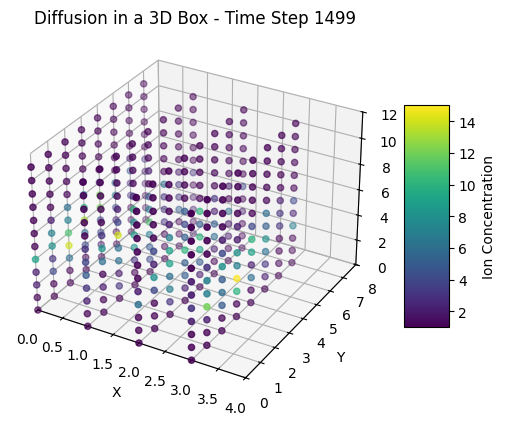

In [4]:
# initialize ion positions
ion_positions = np.column_stack((ion_i % Nx, ion_j % Ny, ion_k % Nz))

# set up plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = update_plot(0)

# colorbar as a legend (only once)
cbar = plt.colorbar(sc, ax=ax, shrink=0.6, aspect=5)
cbar.set_label('Ion Concentration')

# animation
ani = FuncAnimation(fig, update_plot, frames=max_time_steps, repeat=False)

# save animation
writer = FFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
ani.save('newdiffusion3D.mp4', writer=writer)

# display animation
plt.show()